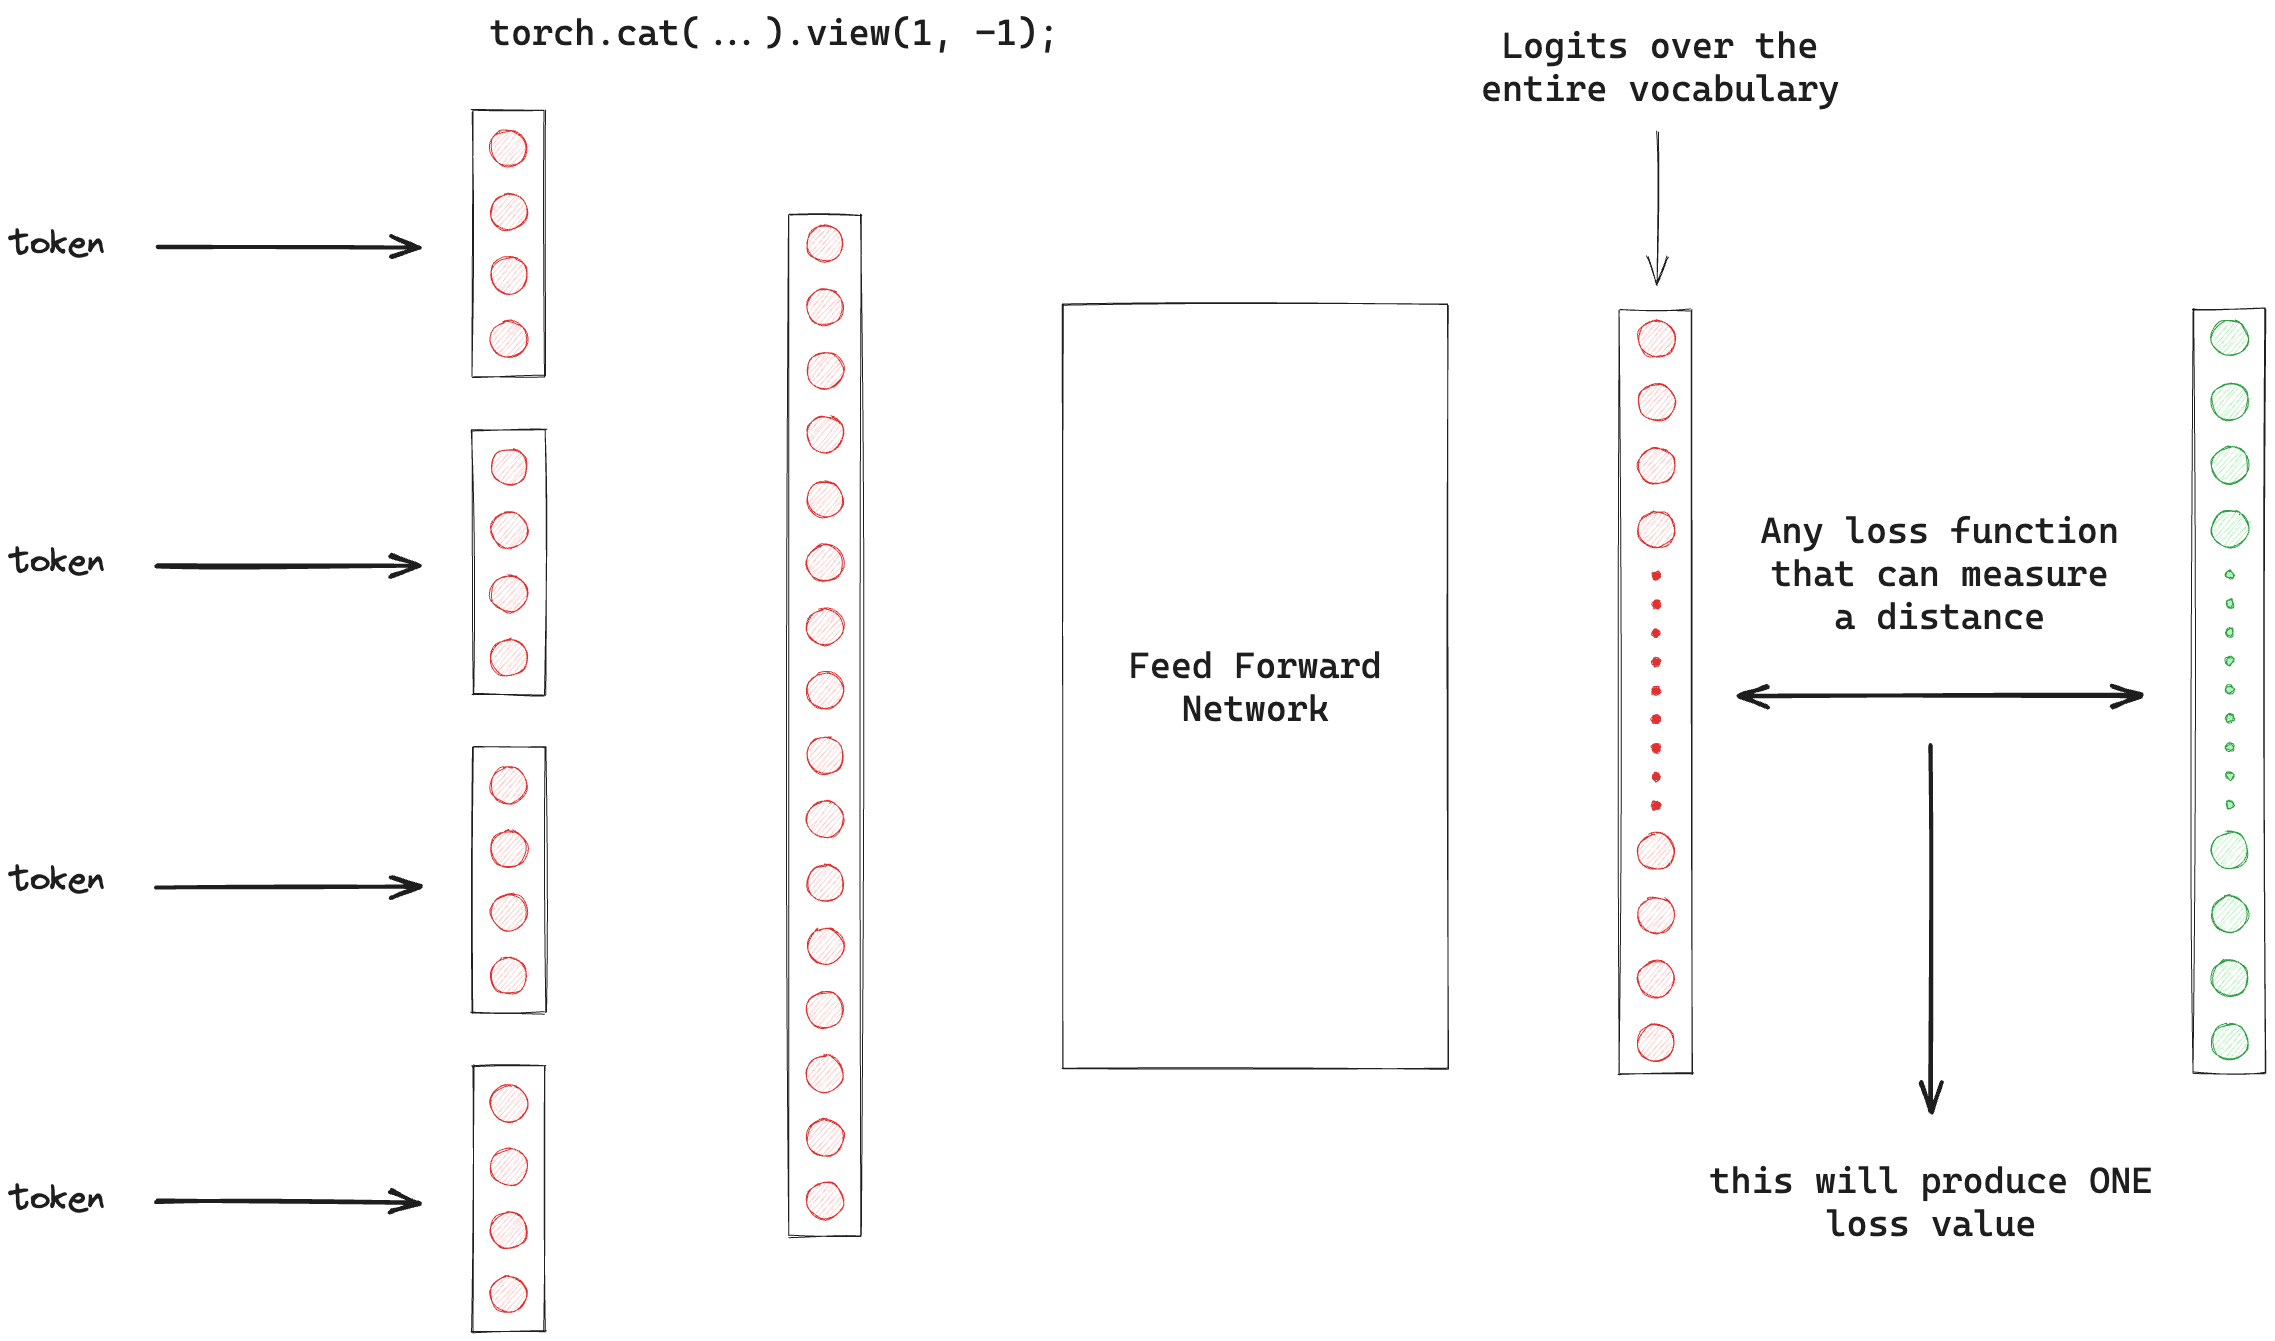

In [ ]:
import torch.nn as nn
import torch
import pickle
import numpy as np

torch.manual_seed(1)

CONTEXT_SIZE = 3
EMBEDDING_DIM = 10
LEARNING_RATE = 0.001
EPOCHS = 100




class Tokenizer():
    # Take the all raw text and create
    # a set of tokens. Thus the only
    # output of the tokeniser is a dictionary
    # of type:
    #  --> { [token_str]: token_num }
    #  --> { [token_num]: token_str }
    def __init__(self, raw_text):
        self.raw_text = raw_text
        self.tokens = self._tokenize()
        self.vocab_size = len(self.tokens)
        self.token2idx = self._token2idx()
        self.idx2token = self._idx2token()
    def _tokenize(self):
        return list(set(self.raw_text.split()))
    def _token2idx(self):
        return {token: idx for idx, token in enumerate(self.tokens)}
    def _idx2token(self):
        return {idx: token for idx, token in enumerate(self.tokens)}
    def __len__(self):
        return self.vocab_size
    def __getitem__(self, token):
        return self.token2idx[token]


    
class TextDataLoader():
    def __init__(self, raw_text, tokenizer):
        self.raw_text = raw_text
        self.tokenizer = tokenizer
        self.data = self._create_data()
    
    def _create_data(self):
        data = []
        for i in range(CONTEXT_SIZE, len(self.raw_text.split()) - CONTEXT_SIZE):
            context = [self.tokenizer[self.raw_text.split()[i + j]] for j in range(-CONTEXT_SIZE, CONTEXT_SIZE + 1) if j != 0]
            target = self.tokenizer[self.raw_text.split()[i]]
            data.append((context, target))
        return data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

class Model(nn.Module):
  # Here we directly put the architecture
  # logic. In our case we need to follow
  # the diagram
    # 1. Embedding
    # 2. FFN
    # 3. Loss
    def __init__(self, vocab_size, embedding_dim, sequence_length):
        super(Model, self).__init__()
        self.embedding_dim = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(sequence_length * embedding_dim, vocab_size)

    def forward(self, input):
        embeddings = self.embedding_dim(input).view((1, -1))
        out = self.linear(embeddings)
        log_probs = nn.functional.log_softmax(out, dim=1)
        return log_probs
    

        
class NNLLoss():
    # NLLLoss is the negative log likelihood loss
    # NLLLoss is defined as:
    #   -1/n * sum( y_i * log(p_i) )
    # where:
    #   - n is the number of samples
    #   - y_i is the true label
    #   - p_i is the predicted label
    def __init__(self):
        self.loss = nn.NLLLoss()
    def __call__(self, y, p):
        return self.loss(y, p)

class Optimizer():
    # Here we define the optimizer
    # that we want to use. In our case
    # we want to use the SGD
    # which is defined as:
    #   - w = w - learning_rate * gradient
    # where:
    #   - w is the weight
    #   - learning_rate is the learning rate
    #   - gradient is the gradient of the loss
    #     with respect to the weight
    def __init__(self, model, learning_rate):
        self.model = model
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)
    def step(self):
        self.optimizer.step()
    def zero_grad(self):
        self.optimizer.zero_grad()

class Trainer():
    # Here we define the training loop
    # that we want to use. In our case
    # we want to use the SGD
    # which is defined as:
    #   - w = w - learning_rate * gradient
    # where:
    #   - w is the weight
    #   - learning_rate is the learning rate
    #   - gradient is the gradient of the loss
    #     with respect to the weight
    def __init__(self, model, optimizer, loss):
        self.model = model
        self.optimizer = optimizer
        self.loss = loss
    def train(self, data):
        for context, target in data:
            self.optimizer.zero_grad()
            context_idxs = torch.tensor(context, dtype=torch.long)
            log_probs = self.model(context_idxs)
            loss = self.loss(log_probs, torch.tensor([target]))
            loss.backward()
            self.optimizer.step()
    def __call__(self, data):
        self.train(data)


def main():
    # 1. Read the data
    with open('data.txt', 'r') as f:
        raw_text = f.read()

    # 2. Tokenize the data
    tokenizer = Tokenizer(raw_text)


    # 4. Create the dataloader
    dataloader = TextDataLoader(raw_text, tokenizer)
 
    # 5. Create the model
    model = Model(tokenizer.vocab_size, EMBEDDING_DIM, CONTEXT_SIZE)
    # 6. Create the loss
    loss = NNLLoss()
    # 7. Create the optimizer
    optimizer = Optimizer(model, LEARNING_RATE)
    # 8. Create the trainer
    trainer = Trainer(model, optimizer, loss)

    # 9. Train the model
    for epoch in range(EPOCHS):
        for i, data in enumerate(dataloader):
            trainer(data)
            if i % 100 == 0:
                print(f'Epoch: {epoch}, Loss: {loss.loss}')

    # 10. Save the model
    torch.save(model.state_dict(), 'model.pth')
    
    # 11. Save the tokenizer
    with open('tokenizer.pth', 'wb') as f:
        pickle.dump(tokenizer, f)

    # 12. Save the optimizer
    with open('optimizer.pth', 'wb') as f:
        pickle.dump(optimizer, f)

if __name__ == "__main__":
    main()

